***

***

# <div align="center"><font color='RED'><b>AREEBA FATAH </b></font></div>

***

# <div align="center"><font color='BLUE'><b>GENERATIVE AI</b></font></div>

***

# <div align="center"><font color='RED'><b>21I-0349</b></font></div>

***

# <div align="center"><font color='BLUE'><b>ASSIGNMENT 2</b></font></div>

***

# <div align="center"><font color='RED'><b>QUESTION 3 </b></font></div>





<br>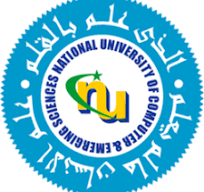

# STEP 1: IMPORTING THE REQUIRED LIBRARIES

In [3]:
import torch

import torch.nn as nn

import torch.optim as optim

from torch.utils.data import Dataset,DataLoader

from torchvision import transforms

from PIL import Image

import os

import matplotlib.pyplot as plt

import pickle

import torch.nn as nn

## 1.1 SETTING UP THE DEVICE

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 2: DATA PREPROCESSING AND LOADING

**Steps**:

    --<br>Reading both the sketches and photos till max limit as dataset is too large.

    --<br>Preprocessing data i.e. resizing and normalizing while converting to tensors

    --<br>Preparing train loader

In [5]:
class FaceSketchDataset(Dataset):

    def __init__(self,sketch_dir,photo_dir,transforms=None,max_images=500):

        self.sketch_dir=sketch_dir

        self.photo_dir=photo_dir

        self.transforms=transforms

        self.sketch_images=os.listdir(sketch_dir)[:max_images]

        

    def __len__(self):

        return len(self.sketch_images)

    

    def __getitem__(self, idx):

        sketch_path=os.path.join(self.sketch_dir,self.sketch_images[idx])

        photo_path=os.path.join(self.photo_dir,self.sketch_images[idx])

        sketch_img=Image.open(sketch_path).convert('L')

        photo_img=Image.open(photo_path).convert('RGB')

        if self.transforms:

            sketch_img=self.transforms[0](sketch_img)

            photo_img=self.transforms[1](photo_img)

        return sketch_img,photo_img


In [6]:
transform_sketch=transforms.Compose([

                                    transforms.Resize((256,256)),

                                    transforms.ToTensor(),

                                    transforms.Normalize(mean=[0.5],std=[0.5])

                                    ])



transform_photo=transforms.Compose([

                                    transforms.Resize((256,256)),

                                    transforms.ToTensor(),

                                    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])

                                   ])



train_dataset=FaceSketchDataset(

                                sketch_dir='/kaggle/input/person-face-sketches/train/sketches',

                                photo_dir='/kaggle/input/person-face-sketches/train/photos',

                                transforms=(transform_sketch,transform_photo),

                                max_images=1000

                                )

train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)

# STEP 3: DESIGNING CONDITIONAL GAN

## 3.1 GENERATOR

- **5 Conv2d layers** for downsampling

- **4 ConvTranspose2d layers** for upsampling

- **ReLU activation** used after each Conv/ConvTranspose layer (except output)

- **Tanh activation** at the output layer (to normalize the output between -1 and 1)

In [7]:
class Generator(nn.Module):

    def __init__(self):

        super(Generator,self).__init__()

        self.main=nn.Sequential(

            nn.Conv2d(1,64,4,2,1),

            nn.ReLU(True),

            nn.Conv2d(64,128,4,2,1),

            nn.BatchNorm2d(128),

            nn.ReLU(True),

            nn.Conv2d(128,256,4,2,1),

            nn.BatchNorm2d(256),

            nn.ReLU(True),

            nn.Conv2d(256,512,4,2,1),

            nn.BatchNorm2d(512),

            nn.ReLU(True),

            nn.Conv2d(512,512,4,2,1),

            nn.ReLU(True),

            nn.ConvTranspose2d(512,512,4,2,1),

            nn.BatchNorm2d(512),

            nn.ReLU(True),

            nn.ConvTranspose2d(512,256,4,2,1),

            nn.BatchNorm2d(256),

            nn.ReLU(True),

            nn.ConvTranspose2d(256,128,4,2,1),

            nn.BatchNorm2d(128),

            nn.ReLU(True),

            nn.ConvTranspose2d(128,64,4,2,1),

            nn.BatchNorm2d(64),

            nn.ReLU(True),

            nn.ConvTranspose2d(64,3,4,2,1),

            nn.Tanh()

        )



    def forward(self,input):

        return self.main(input)


## 3.2 DISCRIMINATOR



- **5 Conv2d layers** for downsampling

- **LeakyReLU activation** used after each Conv layer (with a negative slope of 0.2)

- **BatchNorm2d** applied after the first three Conv layers

- **1 Sigmoid activation** at the output layer 

In [8]:
class Discriminator(nn.Module):

    def __init__(self):

        super(Discriminator,self).__init__()

        self.main=nn.Sequential(

            nn.Conv2d(4,64,4,2,1),

            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64,128,4,2,1),

            nn.BatchNorm2d(128),

            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(128,256,4,2,1),

            nn.BatchNorm2d(256),

            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(256,512,4,2,1),

            nn.BatchNorm2d(512),

            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(512,1,4,1,0),

            nn.Sigmoid()

        )



    def forward(self,input):

        return self.main(input)


# STEP 4 : TRAINING

Training like the previous questions.

In [23]:
G=Generator().to(device)

D=Discriminator().to(device)

optimizer_G=optim.Adam(G.parameters(),lr=0.0002,betas=(0.5,0.999))

optimizer_D=optim.Adam(D.parameters(),lr=0.0002,betas=(0.5,0.999))

criterion=nn.BCELoss()

In [24]:
def train(num_epochs=50):

    G_losses,D_losses=[],[]

    for epoch in range(num_epochs):

        for sketches,real_images in train_loader:

            batch_size=sketches.size(0)

            sketches=sketches.to(device)

            real_images=real_images.to(device)

            optimizer_D.zero_grad()

            real_input=torch.cat((sketches,real_images),1)

            real_output=D(real_input)

            real_labels=torch.ones_like(real_output).to(device)

            fake_images=G(sketches)

            fake_input=torch.cat((sketches,fake_images),1)

            fake_output=D(fake_input)

            fake_labels=torch.zeros_like(fake_output).to(device)

            D_loss=(criterion(real_output,real_labels)+criterion(fake_output,fake_labels))/2

            D_loss.backward()

            optimizer_D.step()

            optimizer_G.zero_grad()

            fake_images=G(sketches)

            fake_input=torch.cat((sketches,fake_images),1)

            fake_output=D(fake_input)

            G_loss=criterion(fake_output,real_labels)

            G_loss.backward()

            optimizer_G.step()

            G_losses.append(G_loss.item())

            D_losses.append(D_loss.item())



        if epoch%10==0:

            print(f"Epoch [{epoch+1}/{num_epochs}] | D_loss: {D_loss.item()} | G_loss: {G_loss.item()}")

            num_samples=min(5,sketches.size(0))

            sample_sketches=sketches[:num_samples]

            generated_images=G(sample_sketches).detach().cpu()

            fig,axs=plt.subplots(2,num_samples,figsize=(12,6))

            for j in range(num_samples):

                axs[0,j].imshow(sample_sketches[j].cpu().squeeze(),cmap='gray')

                axs[0,j].axis('off')

                axs[1,j].imshow((generated_images[j].permute(1,2,0)+1)/2.0)

                axs[1,j].axis('off')

            plt.show()



    plt.figure(figsize=(10,5))

    plt.plot(G_losses,label="G Loss")

    plt.plot(D_losses,label="D Loss")

    plt.xlabel("Iterations")

    plt.ylabel("Loss")

    plt.legend()

    plt.show()

In [2]:
# train(num_epochs=50)

In [3]:
# train(num_epochs=50)

# STEP 4: SAVING MODEL

In [26]:
def save_model_to_pickle(model,filename):

    with open(filename, 'wb') as file:

        pickle.dump(model, file)

save_model_to_pickle(G, 'generator_model_3.pkl')

save_model_to_pickle(D, 'discriminator_model_3.pkl')

In [12]:
def load_model_from_pickle(filename):

    with open(filename,'rb') as file:

        model=pickle.load(file)

    return model



G = load_model_from_pickle('/kaggle/input/model_3/pytorch/default/1/discriminator_model_3.pkl')

D = load_model_from_pickle('/kaggle/input/model_3/pytorch/default/1/generator_model_3.pkl')

In [1]:
# train(num_epochs=50)

# STEP 5 TESTING

In [18]:
test_dataset=FaceSketchDataset(

                                sketch_dir='/kaggle/input/person-face-sketches/test/sketches',

                                photo_dir='/kaggle/input/person-face-sketches/test/photos',

                                transforms=(transform_sketch,transform_photo),

                                max_images=1000

                                )

test_loader=DataLoader(test_dataset,batch_size=16,shuffle=True)

In [4]:
def test(test_loader):
    G.eval()
    G_losses, D_losses = [], []
    with torch.no_grad():
        for sketches, real_images in test_loader:
            sketches = sketches.to(device)
            real_images = real_images.to(device)
            generated_images = G(sketches).detach().cpu()
            num_samples = min(5, sketches.size(0))
            sample_sketches = sketches[:num_samples]
            fig, axs = plt.subplots(2, num_samples, figsize=(12, 6))
            for j in range(num_samples):
                axs[0, j].imshow(sample_sketches[j].cpu().squeeze(), cmap='gray')
                axs[0, j].axis('off')
                axs[1, j].imshow((generated_images[j].permute(1, 2, 0) + 1) / 2.0)
                axs[1, j].axis('off')
            plt.show()
            real_output = D(torch.cat((sketches, real_images), 1))
            real_labels = torch.ones_like(real_output).to(device)
            fake_output = D(torch.cat((sketches, generated_images.to(device)), 1))
            fake_labels = torch.zeros_like(fake_output).to(device)
            D_loss = (criterion(real_output, real_labels) + criterion(fake_output, fake_labels)) / 2
            G_loss = criterion(fake_output, real_labels)
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label='G Validation Loss')
    plt.plot(D_losses, label='D Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# test(test_loader)

***

# <div style="text-align: center;">End</div>


***